In [2]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.2/825.2 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [26]:
import cv2
import numpy as np
from ultralytics import YOLO
import os

In [4]:
# YOLOv8-poseモデルの読み込み
model = YOLO('yolov8n-pose.pt')

100%|██████████| 6.52M/6.52M [00:00<00:00, 24.7MB/s]


In [ ]:
import torch

def extract_keypoints(frames):
    all_keypoints = []
    device = torch.device('mps')  # MPSデバイスを指定
    for frame in frames:
        frame = preprocess_frame(frame)
        frame = torch.tensor(frame, dtype=torch.float32).to(device)  # フレームをGPUに転送
        results = model(frame)

        if len(results) > 0 and len(results[0].keypoints) > 0:
            keypoints_list = results[0].keypoints
            bboxes = results[0].boxes  # バウンディングボックスのリスト

            if bboxes is not None and len(bboxes) > 0:
                # バウンディングボックスの面積を計算
                try:
                    xyxy = bboxes.xyxy.cpu().numpy()  # バウンディングボックスの座標を取得
                    areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in xyxy]
                except IndexError as e:
                    print(f"Error calculating areas: {e}")
                    print(f"Bounding boxes: {bboxes}")
                    continue

                # 最も大きいバウンディングボックスのインデックスを取得
                max_area_index = np.argmax(areas)

                # 最も大きいバウンディングボックスに対応するキーポイントを取得
                keypoints = keypoints_list[max_area_index].xy[0].cpu().numpy()

                all_keypoints.append(keypoints)
            else:
                print(f"Warning: No bounding boxes found in frame.")
        else:
            print(f"Warning: No keypoints found in frame.")

    return all_keypoints  # np.arrayの変換を削除


def normalize_keypoints(keypoints):
    hip_index = 11  #  index of left hip
    shoulder_index = 5  # index of shoulder

    normalized_keypoints = []
    for frame_keypoints in keypoints:
        if len(frame_keypoints) > max(hip_index, shoulder_index):
            hip_point = frame_keypoints[hip_index]
            shoulder_point = frame_keypoints[shoulder_index]

            # 腰のポイントを原点(0,0)とし、他のポイントを相対位置として計算
            relative_points = frame_keypoints - hip_point

            # スケーリング、モデルをロバストにするため
            scale_factor = np.linalg.norm(shoulder_point - hip_point)
            if scale_factor != 0:
                relative_points /= scale_factor

            normalized_keypoints.append(relative_points)
        else:
            print(f"Warning: Frame with insufficient keypoints detected. Skipping this frame.")

    return np.array(normalized_keypoints)

def process_folder(folder_path, label):
    print(f"Processing folder: {folder_path}")
    video_data = []
    for video_file in os.listdir(folder_path):
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(folder_path, video_file)
            frames = process_video(video_path)
            keypoints = extract_keypoints(frames)
            if len(keypoints) > 0:
                normalized_keypoints = normalize_keypoints(keypoints)
                if len(normalized_keypoints) > 0:
                    video_data.append((normalized_keypoints, label))
                else:
                    print(f"Warning: No valid keypoints found in video {video_file}")
            else:
                print(f"Warning: No keypoints detected in video {video_file}")
    return video_data

    # デバッグ情報の出力
    print(f"Number of videos processed: {len(video_data)}")

# 全てのショットタイプを処理
shot_types = ['forehand_stroke','forehand_slice','forehand_volley', 'backhand_stroke', 'backhand_volley', 'backhand_slice']
all_data = []
for label, shot_type in enumerate(shot_types):
    folder_path = f'/Users/yusuke.s/Documents/pickleball_videos/{shot_type}'
    all_data.extend(process_folder(folder_path, label))

Processing folder: /Users/yusuke.s/Documents/pickleball_videos/forehand_stroke



0: 640x640 1 person, 488.9ms
Speed: 42.5ms preprocess, 488.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 357.8ms
Speed: 3.3ms preprocess, 357.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 375.7ms
Speed: 39.1ms preprocess, 375.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 306.2ms
Speed: 5.8ms preprocess, 306.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 456.7ms
Speed: 3.4ms preprocess, 456.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 381.2ms
Speed: 2.5ms preprocess, 381.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 903.8ms
Speed: 3.9ms preprocess, 903.8ms inference, 31.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1260.9ms
Speed: 43.9ms preprocess, 1260.9ms inference, 54.5ms postprocess per 

Processing folder: /Users/yusuke.s/Documents/pickleball_videos/forehand_slice


0: 640x640 2 persons, 398.6ms
Speed: 2.5ms preprocess, 398.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 297.7ms
Speed: 2.1ms preprocess, 297.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 298.1ms
Speed: 2.2ms preprocess, 298.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 297.8ms
Speed: 2.1ms preprocess, 297.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 324.8ms
Speed: 2.2ms preprocess, 324.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 297.3ms
Speed: 2.1ms preprocess, 297.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 293.2ms
Speed: 1.9ms preprocess, 293.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 312.0ms
Speed: 2.2ms preprocess, 312.0ms inference, 3.3ms postprocess per i

Processing folder: /Users/yusuke.s/Documents/pickleball_videos/forehand_volley


0: 640x640 1 person, 297.3ms
Speed: 2.4ms preprocess, 297.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 345.3ms
Speed: 2.3ms preprocess, 345.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 626.0ms
Speed: 7.0ms preprocess, 626.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 385.1ms
Speed: 10.5ms preprocess, 385.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 298.9ms
Speed: 2.4ms preprocess, 298.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 305.9ms
Speed: 2.2ms preprocess, 305.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 306.8ms
Speed: 2.1ms preprocess, 306.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 325.6ms
Speed: 2.3ms preprocess, 325.6ms inference, 3.4ms postprocess per imag

0: 640x640 1 person, 306.4ms
Speed: 1.9ms preprocess, 306.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 298.1ms
Speed: 2.1ms preprocess, 298.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 287.7ms
Speed: 2.3ms preprocess, 287.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 326.5ms
Speed: 2.2ms preprocess, 326.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 295.0ms
Speed: 2.1ms preprocess, 295.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 298.4ms
Speed: 2.3ms preprocess, 298.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 291.3ms
Speed: 2.3ms preprocess, 291.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 286.7ms
Speed: 2.1ms preprocess, 286.7ms inference, 3.0ms postprocess per image at 

0: 640x640 1 person, 301.0ms
Speed: 2.0ms preprocess, 301.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 324.5ms
Speed: 2.2ms preprocess, 324.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 352.3ms
Speed: 2.0ms preprocess, 352.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 297.1ms
Speed: 2.3ms preprocess, 297.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 298.1ms
Speed: 2.0ms preprocess, 298.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 292.2ms
Speed: 1.9ms preprocess, 292.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 312.2ms
Speed: 2.0ms preprocess, 312.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 508.2ms
Speed: 2.7ms preprocess, 508.2ms inference, 5.6ms postprocess per image at 

0: 640x640 2 persons, 406.3ms
Speed: 2.5ms preprocess, 406.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 378.3ms
Speed: 4.9ms preprocess, 378.3ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 374.6ms
Speed: 2.2ms preprocess, 374.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 460.8ms
Speed: 2.2ms preprocess, 460.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 389.9ms
Speed: 2.1ms preprocess, 389.9ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 837.3ms
Speed: 23.0ms preprocess, 837.3ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 407.6ms
Speed: 4.5ms preprocess, 407.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 330.0ms
Speed: 2.6ms preprocess, 330.0ms inference, 3.2ms postprocess per ima

0: 640x640 1 person, 645.3ms
Speed: 2.7ms preprocess, 645.3ms inference, 18.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 505.9ms
Speed: 6.9ms preprocess, 505.9ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 400.4ms
Speed: 2.5ms preprocess, 400.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 400.5ms
Speed: 2.3ms preprocess, 400.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 384.9ms
Speed: 2.6ms preprocess, 384.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 331.6ms
Speed: 2.2ms preprocess, 331.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 330.7ms
Speed: 2.2ms preprocess, 330.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 321.8ms
Speed: 3.4ms preprocess, 321.8ms inference, 3.0ms postprocess per im

0: 640x640 3 persons, 324.3ms
Speed: 2.1ms preprocess, 324.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 307.3ms
Speed: 2.0ms preprocess, 307.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 310.5ms
Speed: 2.4ms preprocess, 310.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 319.3ms
Speed: 2.0ms preprocess, 319.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 344.8ms
Speed: 2.2ms preprocess, 344.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 335.2ms
Speed: 2.3ms preprocess, 335.2ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 360.4ms
Speed: 5.5ms preprocess, 360.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 309.0ms
Speed: 2.3ms preprocess, 309.0ms inference, 3.0ms postprocess per im

Processing folder: /Users/yusuke.s/Documents/pickleball_videos/backhand_stroke


0: 640x640 1 person, 327.9ms
Speed: 2.1ms preprocess, 327.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 297.8ms
Speed: 2.3ms preprocess, 297.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 298.6ms
Speed: 1.9ms preprocess, 298.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 299.5ms
Speed: 2.6ms preprocess, 299.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 300.4ms
Speed: 2.3ms preprocess, 300.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 298.5ms
Speed: 1.9ms preprocess, 298.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 303.8ms
Speed: 2.1ms preprocess, 303.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 299.5ms
Speed: 3.4ms preprocess, 299.5ms inference, 2.9ms postprocess per image at 

0: 640x640 1 person, 315.9ms
Speed: 2.3ms preprocess, 315.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 284.6ms
Speed: 2.2ms preprocess, 284.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 283.3ms
Speed: 2.0ms preprocess, 283.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.5ms
Speed: 2.0ms preprocess, 280.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 290.1ms
Speed: 1.9ms preprocess, 290.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.6ms
Speed: 2.1ms preprocess, 280.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 284.6ms
Speed: 2.0ms preprocess, 284.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.3ms
Speed: 2.1ms preprocess, 280.3ms inference, 2.9ms postprocess per image at 

0: 640x640 1 person, 374.6ms
Speed: 2.0ms preprocess, 374.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 306.7ms
Speed: 2.3ms preprocess, 306.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 289.0ms
Speed: 2.0ms preprocess, 289.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 393.6ms
Speed: 40.5ms preprocess, 393.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 295.2ms
Speed: 2.9ms preprocess, 295.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 288.0ms
Speed: 2.1ms preprocess, 288.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 284.8ms
Speed: 2.5ms preprocess, 284.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 283.8ms
Speed: 1.9ms preprocess, 283.8ms inference, 2.9ms postprocess per image at

Processing folder: /Users/yusuke.s/Documents/pickleball_videos/backhand_volley


0: 640x640 2 persons, 313.3ms
Speed: 2.0ms preprocess, 313.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 293.5ms
Speed: 2.1ms preprocess, 293.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 289.8ms
Speed: 1.9ms preprocess, 289.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 283.5ms
Speed: 2.1ms preprocess, 283.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 297.2ms
Speed: 2.1ms preprocess, 297.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 294.1ms
Speed: 2.2ms preprocess, 294.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 574.2ms
Speed: 2.5ms preprocess, 574.2ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 374.7ms
Speed: 3.0ms preprocess, 374.7ms inference, 3.2ms postprocess per ima

Processing folder: /Users/yusuke.s/Documents/pickleball_videos/backhand_slice


0: 640x640 1 person, 305.7ms
Speed: 2.1ms preprocess, 305.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 281.5ms
Speed: 2.0ms preprocess, 281.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 279.9ms
Speed: 1.9ms preprocess, 279.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 281.9ms
Speed: 2.0ms preprocess, 281.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.0ms
Speed: 2.0ms preprocess, 280.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 279.9ms
Speed: 2.0ms preprocess, 279.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.0ms
Speed: 1.9ms preprocess, 280.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.8ms
Speed: 2.1ms preprocess, 280.8ms inference, 2.9ms postprocess per image at 

0: 640x640 1 person, 337.1ms
Speed: 1.9ms preprocess, 337.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 282.7ms
Speed: 1.9ms preprocess, 282.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.9ms
Speed: 2.0ms preprocess, 280.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 279.5ms
Speed: 2.0ms preprocess, 279.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 282.4ms
Speed: 2.0ms preprocess, 282.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.5ms
Speed: 1.9ms preprocess, 280.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 282.4ms
Speed: 2.0ms preprocess, 282.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.7ms
Speed: 2.0ms preprocess, 280.7ms inference, 2.8ms postprocess per image at 

0: 640x640 1 person, 282.0ms
Speed: 2.2ms preprocess, 282.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 282.6ms
Speed: 2.0ms preprocess, 282.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 282.8ms
Speed: 2.0ms preprocess, 282.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.0ms
Speed: 2.3ms preprocess, 280.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 281.3ms
Speed: 2.0ms preprocess, 281.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 279.4ms
Speed: 2.0ms preprocess, 279.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 280.7ms
Speed: 1.9ms preprocess, 280.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 279.4ms
Speed: 2.0ms preprocess, 279.4ms inference, 2.9ms postprocess per image at 

In [ ]:
"""import numpy as np
# Convert to numpy array
all_data_array = np.array(all_data, dtype=object)
# Save to .npy file
np.save('all_data.npy', all_data_array)"""

"import numpy as np\n# Convert to numpy array\nall_data_array = np.array(all_data, dtype=object)\n# Save to .npy file\nnp.save('all_data.npy', all_data_array)"

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import numpy as np
all_data = np.load('/content/drive/MyDrive/all_data.npy', allow_pickle=True)

In [8]:
def pad_sequences(sequences, max_length):
    # シーケンスの長さを揃える
    return [seq[:max_length] if len(seq) > max_length else np.pad(seq, ((0, max_length - len(seq)), (0, 0), (0, 0)), 'constant') for seq in sequences]

# データの整形
X = [data[0] for data in all_data]
y = [data[1] for data in all_data]

# シーケンスの長さを揃える（例：最大150フレーム）
X_padded = pad_sequences(X, 150)

# numpy配列に変換
X_array = np.array(X_padded)
y_array = np.array(y)

# one-hot エンコーディング
shot_types = ['forehand_stroke','forehand_slice','forehand_volley', 'backhand_stroke', 'backhand_volley', 'backhand_slice']
y_onehot = np.eye(len(shot_types))[y_array]

In [9]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, AdditiveAttention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

def create_lstm_attention_model(sequence_length, num_keypoints, num_coords, num_classes):
    inputs = Input(shape=(sequence_length, num_keypoints * num_coords))
    x = LSTM(128, return_sequences=True)(inputs)
    attention = AdditiveAttention()([x, x])
    x = Concatenate()([x, attention])
    x = LSTM(64, return_sequences=True)(x)
    attention = AdditiveAttention()([x, x])
    x = Concatenate()([x, attention])
    x = LSTM(32)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# トレーニング、検証、テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_array, y_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# データの形状を変更
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

# データジェネレータの作成
train_generator = DataGenerator(X_train, y_train, batch_size=16)
val_generator = DataGenerator(X_val, y_val, batch_size=16)
test_generator = DataGenerator(X_test, y_test, batch_size=16)

# モデルの作成
sequence_length = X_train.shape[1]
num_keypoints = 17
num_coords = 2
num_classes = 6
model = create_lstm_attention_model(sequence_length, num_keypoints, num_coords, num_classes)

# クラス重みの計算
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Early Stoppingの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# モデルのトレーニング
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# モデルの評価
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")


Epoch 1/100


KeyboardInterrupt: 

In [22]:
# モデル全体を保存
model.save('swing_class.h5')

print("モデルが保存されました。")

モデルが保存されました。


In [30]:
from tensorflow.keras.models import load_model

# 保存したモデルを読み込む
loaded_model = load_model('/content/drive/MyDrive/swing_class.h5')

# モデルを使用して予測を行う
predictions = loaded_model.predict(test_generator)



5/5 [==============================] - 5s 554ms/step


In [58]:
pred_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(y_test, axis=1)

accuracy = np.mean(pred_labels == true_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8000


In [61]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(true_labels, pred_labels)

<Axes: >

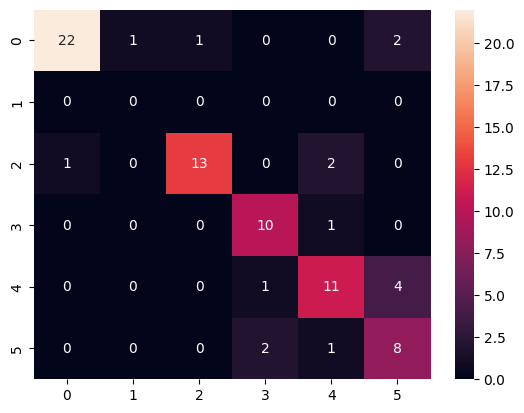

In [63]:
import seaborn as sns
sns.heatmap(matrix, annot=True)

In [8]:
def pad_sequences(sequences, max_length):
    # シーケンスの長さを揃える
    return [seq[:max_length] if len(seq) > max_length else np.pad(seq, ((0, max_length - len(seq)), (0, 0), (0, 0)), 'constant') for seq in sequences]

# データの整形
X = [data[0] for data in all_data]
y = [data[1] for data in all_data]

# シーケンスの長さを揃える（例：最大150フレーム）
X_padded = pad_sequences(X, 150)

# numpy配列に変換
X_array = np.array(X_padded)
y_array = np.array(y)

# one-hot エンコーディング
shot_types = ['forehand_stroke','forehand_slice','forehand_volley', 'backhand_stroke', 'backhand_volley', 'backhand_slice']
y_onehot = np.eye(len(shot_types))[y_array]

In [9]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

def create_lstm_attention_model(sequence_length, num_keypoints, num_coords, num_classes):
    inputs = Input(shape=(sequence_length, num_keypoints * num_coords))
    x = LSTM(128, return_sequences=True)(inputs)
    attention = AdditiveAttention()([x, x])
    x = Concatenate()([x, attention])
    x = LSTM(64, return_sequences=True)(x)
    attention = AdditiveAttention()([x, x])
    x = Concatenate()([x, attention])
    x = LSTM(32)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model_2 = Model(inputs, outputs)
    model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model_2

# トレーニング、検証、テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_array, y_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# データの形状を変更
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

# データジェネレータの作成
train_generator = DataGenerator(X_train, y_train, batch_size=32)
val_generator = DataGenerator(X_val, y_val, batch_size=32)
test_generator = DataGenerator(X_test, y_test, batch_size=32)

# モデルの作成
sequence_length = X_train.shape[1]
num_keypoints = 17
num_coords = 2
num_classes = 6
model_2 = create_lstm_attention_model(sequence_length, num_keypoints, num_coords, num_classes)

# クラス重みの計算
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Early Stoppingの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# モデルのトレーニング
history = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# モデルの評価
test_loss, test_accuracy = model_2.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")


Epoch 1/100
8/8 [==============================] - 40s 4s/step - loss: 1.7852 - accuracy: 0.2372 - val_loss: 1.7819 - val_accuracy: 0.2656
Epoch 2/100
8/8 [==============================] - 31s 4s/step - loss: 1.7895 - accuracy: 0.1660 - val_loss: 1.7789 - val_accuracy: 0.2656
Epoch 3/100
8/8 [==============================] - 28s 3s/step - loss: 1.8013 - accuracy: 0.2016 - val_loss: 1.7785 - val_accuracy: 0.2656
Epoch 4/100
8/8 [==============================] - 29s 4s/step - loss: 1.7893 - accuracy: 0.2253 - val_loss: 1.7784 - val_accuracy: 0.2656
Epoch 5/100
8/8 [==============================] - 30s 4s/step - loss: 1.7825 - accuracy: 0.2095 - val_loss: 1.7771 - val_accuracy: 0.2656
Epoch 6/100
8/8 [==============================] - 31s 4s/step - loss: 1.7882 - accuracy: 0.1897 - val_loss: 1.7751 - val_accuracy: 0.2656
Epoch 7/100
8/8 [==============================] - 30s 4s/step - loss: 1.7862 - accuracy: 0.2174 - val_loss: 1.7733 - val_accuracy: 0.2656
Epoch 8/100
8/8 [==========